In [7]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt #used for only visualization, not used for img processing

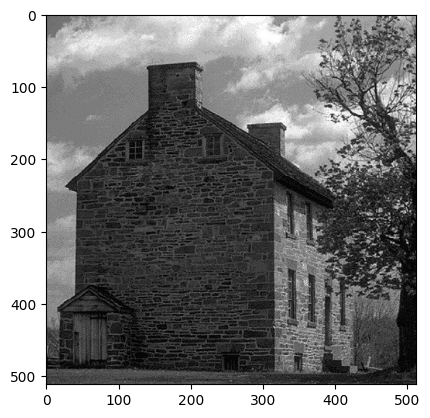

In [8]:
#original img
org = cv2.imread('house.jpg')
b, g, r = org[:,:,0], org[:,:,1], org[:,:,2]
org = np.dstack((r, g, b))
w, h, _ = org.shape
plt.imshow(org)
plt.show()

In [9]:
#Since gray image -> r = g = b
print((r == g).all())
print((g == b).all())

True
True


In [10]:
def get_psnr(img1, img2):
  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    raise Exception("MSE is 0")
  psnr = 10 * math.log10(255 **2 / mse)
  return psnr

**Gaussian noise and Mean filter**

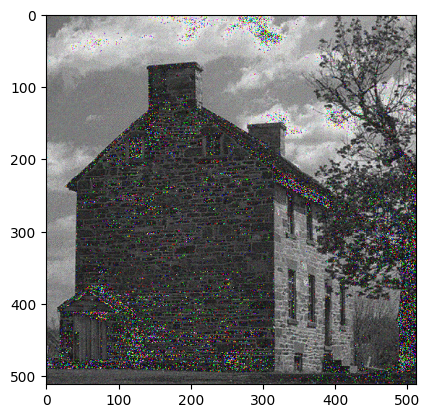

In [11]:
std = 10
np.random.seed(0)
noise = (org + np.random.normal(0, std, org.shape)).astype(np.uint8)
plt.imshow(noise)
plt.show()

In [12]:
psnr_noise = get_psnr(org, noise)
print(f"psnr for noisy image: {psnr_noise}")

psnr for noisy image: 30.309569983383902


In [13]:
def apply_filter(img, kernel, kSize):
  offset = kSize // 2
  ret = np.zeros((h, w, 3))
  for ch in range(3):
    for i in range(h):
      for j in range(w):
        if i < offset or i > h - offset - 1 or j < offset or j > w - offset - 1:
          ret[i][j][ch] = img[i][j][ch]
          continue
        #decide val for ret[i][j]
        i_st = i - offset
        j_st = j - offset
        val = 0
        for k in range(kSize):
          for l in range(kSize):
            val += img[k + i_st][l + j_st][ch] * kernel[k][l]
        ret[i][j][ch] = val
  return ret.astype(np.uint8)

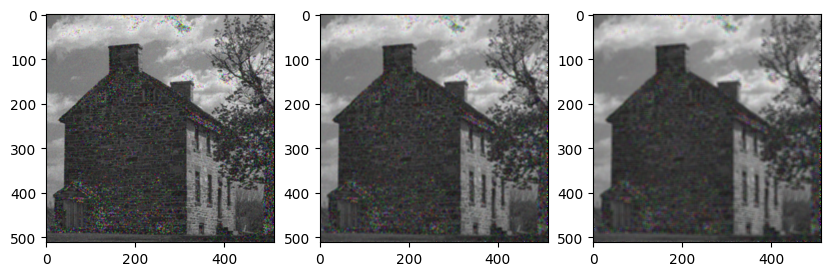

In [27]:
mean3f = np.ones((3, 3)) / 9
mean5f = np.ones((5, 5)) / 25
mean7f = np.ones((7, 7)) / 49
mean3 = apply_filter(noise, mean3f, 3)
mean5 = apply_filter(noise, mean5f, 5)
mean7 = apply_filter(noise, mean7f, 7)

fig, ax = plt.subplots(1, 3, figsize=(10, 6))
ax[0].imshow(mean3)
ax[1].imshow(mean5)
ax[2].imshow(mean7)
plt.show()

In [15]:
psnr_mean3 = get_psnr(org, mean3)
psnr_mean5 = get_psnr(org, mean5)
psnr_mean7 = get_psnr(org, mean7)
print(f"psnr for 3 * 3 mean filter : {psnr_mean3}")
print(f"psnr for 5 * 5 mean filter : {psnr_mean5}")
print(f"psnr for 7 * 7 mean filter : {psnr_mean7}")

psnr for 3 * 3 mean filter : 29.074126382735173
psnr for 5 * 5 mean filter : 28.867794175257607
psnr for 7 * 7 mean filter : 28.788254167483945


**unSharp mask**

In [16]:
def getGaussian(size, std):
  ret = np.zeros((size, size))
  for i in range(size):
    for j in range(size):
      x = (i - size // 2)
      y = (j - size // 2)
      ret[i][j] = np.exp(-(x ** 2 + y ** 2) / (2 * std ** 2)) / (2 * np.pi * std ** 2)
  ret /= ret.sum()
  return ret

tst = apply_filter(org, getGaussian(3, 3), 3)

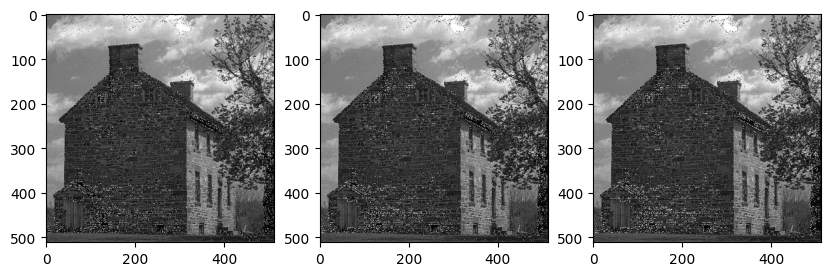

In [26]:
alpha = 0.1
std = 5
sharp3f = (1 + alpha) * np.array([[1 if i == 1 and j == 1 else 0 for j in range(3)] for i in range(3)]) - alpha * getGaussian(3, std)
sharp5f = (1 + alpha) * np.array([[1 if i == 2 and j == 2 else 0 for j in range(5)] for i in range(5)]) - alpha * getGaussian(5, std)
sharp7f = (1 + alpha) * np.array([[1 if i == 3 and j == 3 else 0 for j in range(7)] for i in range(7)]) - alpha * getGaussian(7, std)

sharp3 = apply_filter(org, sharp3f, 3)
sharp5 = apply_filter(org, sharp5f, 5)
sharp7 = apply_filter(org, sharp7f, 7)

fig, ax = plt.subplots(1, 3, figsize=(10, 6))
ax[0].imshow(sharp3)
ax[1].imshow(sharp5)
ax[2].imshow(sharp7)
plt.show()

In [18]:
psnr_sharp3 = get_psnr(org, sharp3)
psnr_sharp5 = get_psnr(org, sharp5)
psnr_sharp7 = get_psnr(org, sharp7)
print(f"psnr for 3 * 3 sharp filter : {psnr_sharp3}")
print(f"psnr for 5 * 5 sharp filter : {psnr_sharp5}")
print(f"psnr for 7 * 7 sharp filter : {psnr_sharp7}")

psnr for 3 * 3 sharp filter : 43.144220914932596
psnr for 5 * 5 sharp filter : 41.4087564117866
psnr for 7 * 7 sharp filter : 40.72106026211528


**Contrast stretching & Gamma correction**

psnr : 27.810470838449245


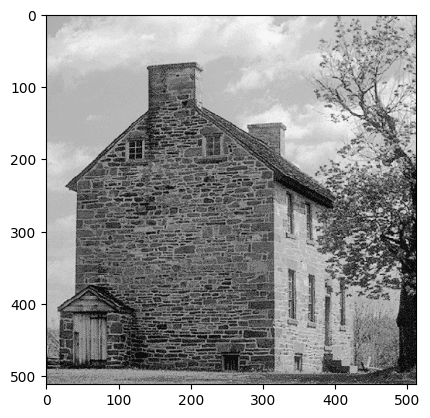

In [19]:
def stretchContrast(u, a, b, c, x1, x2):
  if u < x1:
    return a * u
  elif u < x2:
    return b * (u - x1) + a * x1
  else:
    return c * (u - x2) + b * (x2 - x1) + a * x1

stretch_vec = np.vectorize(stretchContrast)
contrast = stretch_vec(org, 2, 0.5, 0.5, 80, 160).astype(np.uint8)
psnr_stretch = get_psnr(org, contrast)
print(f"psnr : {psnr_stretch}")
plt.imshow(contrast)
plt.show()

psnr : 27.82914395663657


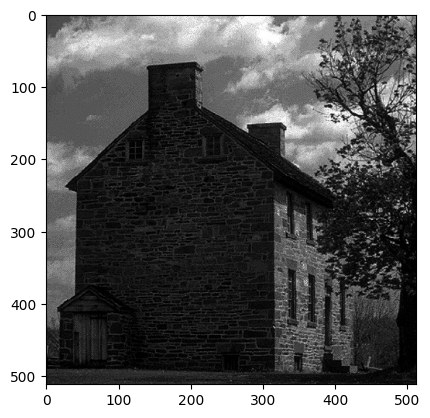

In [20]:
def correctGamma(u, gamma):
  return 255 * (u / 255) ** gamma

gammaVec = np.vectorize(correctGamma)
gamma = gammaVec(org, 1.5).astype(np.uint8)
psnr_gamma = get_psnr(org, gamma)
print(f"psnr : {psnr_gamma}")
plt.imshow(gamma)
plt.show()


**Histogram Equalization**

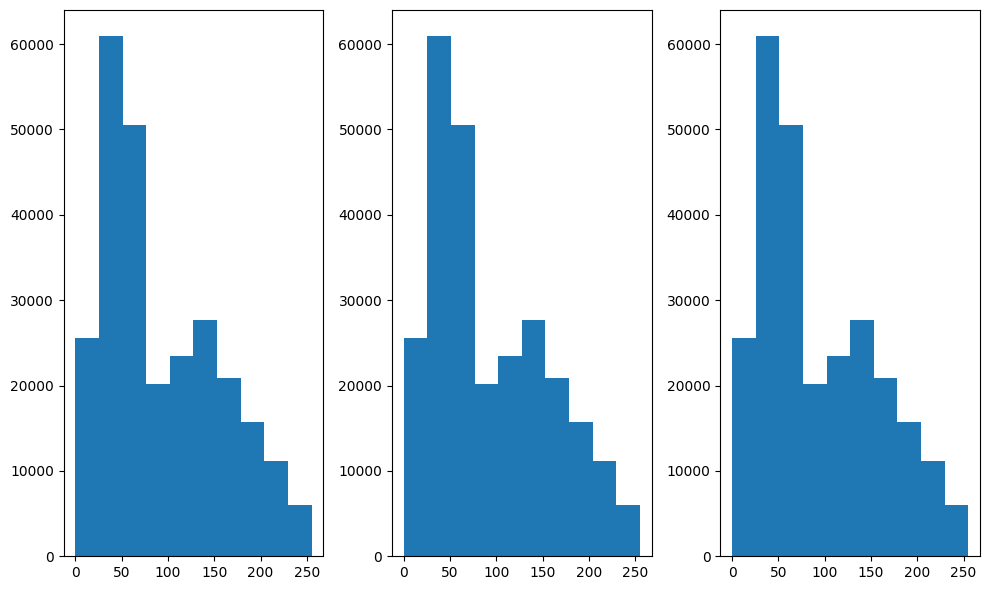

In [21]:
#original hist
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
r, g, b = org[:,:,0], org[:,:,1], org[:,:,2]
ax[0].hist(r.flatten())
ax[1].hist(g.flatten())
ax[2].hist(b.flatten())
plt.tight_layout()
plt.show()

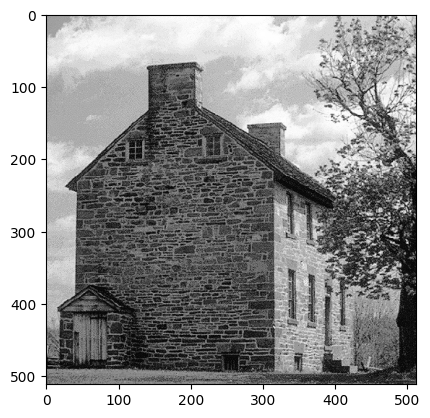

In [22]:
#histogram equalization
def equalHist(img):
  freq = np.zeros(256)
  ret = np.zeros((h, w))
  for i in range(h):
    for j in range(w):
      freq[img[i][j]] += 1
  for i in range(1, 256):
    freq[i] += freq[i - 1]
  freq /= w * h
  for i in range(h):
    for j in range(w):
      ret[i][j] = freq[img[i][j]] * 255
  return ret.astype(np.uint8)

r_eq = equalHist(r)
g_eq = equalHist(g)
b_eq = equalHist(b)
equal = np.dstack((r_eq, g_eq, b_eq))
plt.imshow(equal)
plt.show()

psnr : 28.038156456501753


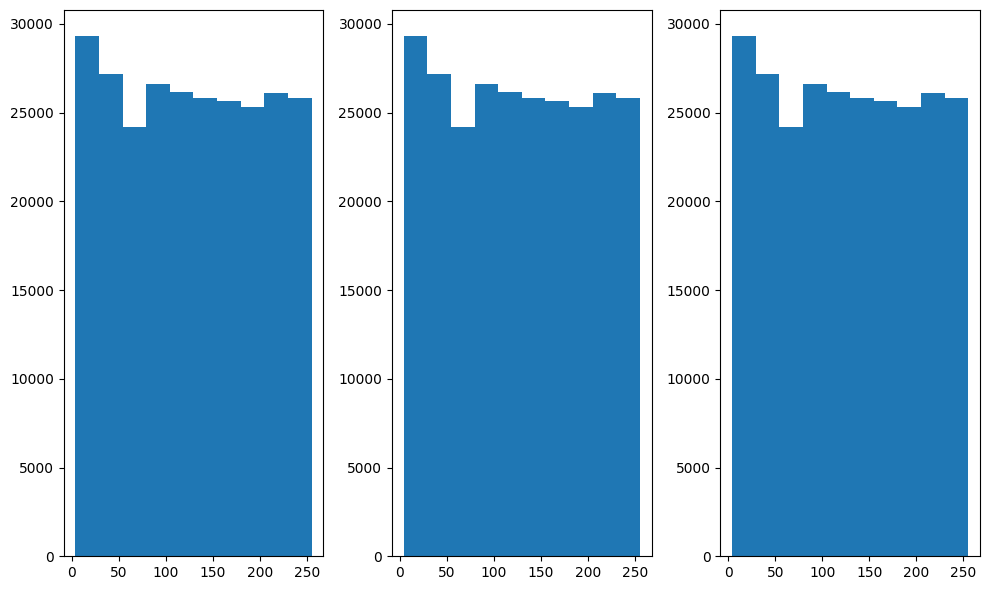

In [23]:
psnr_equal = get_psnr(org, equal)
print(f"psnr : {psnr_equal}")

#original hist
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
ax[0].hist(r_eq.flatten())
ax[1].hist(g_eq.flatten())
ax[2].hist(b_eq.flatten())
plt.tight_layout()
plt.show()

**Image upsampling**

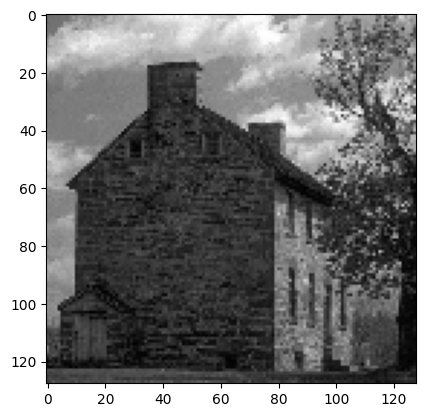

In [24]:
down = cv2.resize(org, (h//4, w//4))
plt.imshow(down)
plt.show()

psrn for nearest neighbor interpolation is 28.988582022226076
psrn for bilinear interpolation is 29.002771605236795
psrn for bicubic interpolation is 28.979649595641135


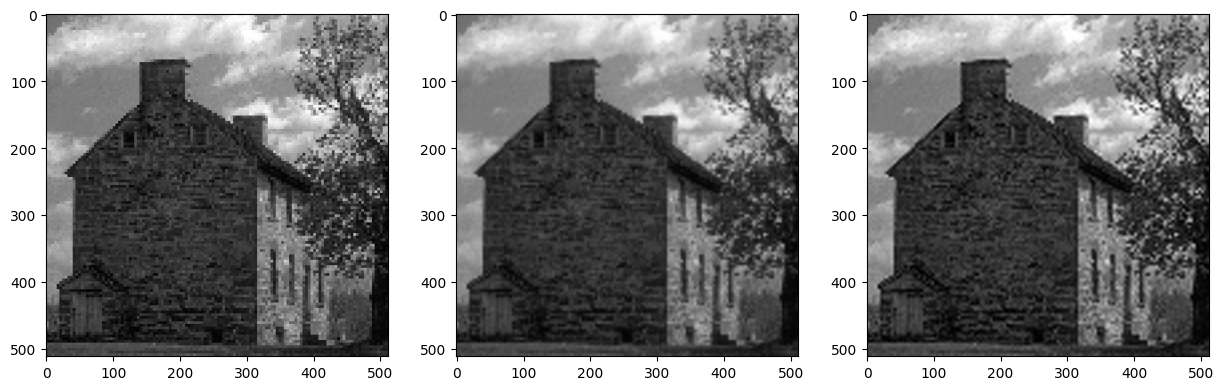

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
neighbor = cv2.resize(down, (h, w), interpolation=cv2.INTER_NEAREST)
linear = cv2.resize(down, (h, w), interpolation=cv2.INTER_LINEAR)
cubic = cv2.resize(down, (h, w), interpolation=cv2.INTER_CUBIC)
ax[0].imshow(neighbor)
ax[1].imshow(linear)
ax[2].imshow(cubic)
psnr_neighbor = get_psnr(org, neighbor)
psnr_linear = get_psnr(org, linear)
psnr_cubic = get_psnr(org, cubic)
print(f"psrn for nearest neighbor interpolation is {psnr_neighbor}")
print(f"psrn for bilinear interpolation is {psnr_linear}")
print(f"psrn for bicubic interpolation is {psnr_cubic}")
plt.show()